# Import Libraries

In [ ]:
!pip install transformers datasets accelerate evaluate langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=6cf0bdcb0f289a03bc3d936b7eb2b7b58a8c06aa3e41e059525db88960554ba8
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [ ]:
import pandas as pd
import numpy as np
from langdetect import detect, LangDetectException
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt

# Set Up Dataframes

In [ ]:
df_youtube = pd.read_csv("hf://datasets/AmaanP314/youtube-comment-sentiment/youtube-comments-sentiment.csv")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print("The shape of the youtube dataframe is: ", df_youtube.shape)
print("The Columns of the youtube dataframe are: ", df_youtube.columns)

The shape of the youtube dataframe is:  (1032225, 12)
The Columns of the youtube dataframe are:  Index(['CommentID', 'VideoID', 'VideoTitle', 'AuthorName', 'AuthorChannelID',
       'CommentText', 'Sentiment', 'Likes', 'Replies', 'PublishedAt',
       'CountryCode', 'CategoryID'],
      dtype='object')


In [ ]:
df_skroutz= pd.read_excel("Skroutz_dataset.xlsx")

In [ ]:
print("The shape of the skroutz dataframe is: ", df_skroutz.shape)
print("The Columns of the skroutz dataframe are: ", df_skroutz.columns)

The shape of the skroutz dataframe is:  (6552, 3)
The Columns of the skroutz dataframe are:  Index(['id', 'review', 'label'], dtype='object')


## Edit Youtube Dataframe

The only columns that are useful for the project are the CommentText, Sentiment

In [ ]:
df_youtube= df_youtube[["CommentText", "Sentiment"]]
df_youtube.columns

Index(['CommentText', 'Sentiment'], dtype='object')

### Check values of Sentiment column

In [ ]:
df_youtube['Sentiment'].value_counts()

,count
Sentiment,
Negative,346075
Positive,343317
Neutral,342833


### For the purposes of this project, only the records in the Sentiment column with values Negative and Positive are retained.

In [ ]:
df_youtube= df_youtube[(df_youtube["Sentiment"] == "Negative") | (df_youtube["Sentiment"] == "Positive")]

### Detect Languages in the youtube dataframe

In [ ]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

df_youtube['lang'] = df_youtube['CommentText'].apply(detect_language)

In [ ]:
total_languages = df_youtube['lang'].nunique()
top_languages = df_youtube['lang'].value_counts().head(10)

print("-" * 30)
print(f"Total number of languages: {total_languages}")
print("-" * 30)
print("Top 10 Languages:")
print(top_languages)

------------------------------
Total number of languages: 56
------------------------------
Top 10 Languages:
lang
en         594188
unknown     10889
tl          10316
ru           5800
so           5580
de           5122
af           4855
es           4818
id           4768
fr           4540
Name: count, dtype: int64


### Keep only 30000 samples per Sentiment

In [ ]:
def stratified_sample(df, n_samples):
  seed= 42
  counts = df['lang'].value_counts()

  total = counts.sum()
  fractions = counts / total

  number_per_lang = (fractions * n_samples).round().astype(int)

  sampled = []
  for lang, n in number_per_lang.items():
      sampled.append(df[df['lang'] == lang].sample(n=min(n, len(df[df['lang'] == lang])), random_state= seed))

  return pd.concat(sampled)

In [ ]:
number_of_samples = 30000

pos_df = stratified_sample(df_youtube[df_youtube['Sentiment'] == 'Positive'], number_of_samples)
neg_df = stratified_sample(df_youtube[df_youtube['Sentiment'] == 'Negative'], number_of_samples)

balanced_df = pd.concat([pos_df, neg_df])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
df_youtube= balanced_df

In [ ]:
df_youtube['Sentiment'].value_counts()

,count
Sentiment,
Negative,30000
Positive,29998


In [ ]:
total_languages = df_youtube['lang'].nunique()
top_languages = df_youtube['lang'].value_counts().head(10)

print("-" * 30)
print(f"Total number of languages: {total_languages}")
print("-" * 30)
print("Top 10 Languages:")
print(top_languages)

------------------------------
Total number of languages: 50
------------------------------
Top 10 Languages:
lang
en         51708
unknown      950
tl           897
ru           504
so           487
de           446
af           423
es           420
id           415
fr           395
Name: count, dtype: int64


### Converting Categorical Labels to Numerical Values

The labels are transformed from categorical values to numerical form using a binary encoding scheme (1, 0).

In [ ]:
df_youtube['Sentiment'] = df_youtube['Sentiment'].map({'Positive': 1, 'Negative': 0})

In [ ]:
df_youtube['Sentiment'].value_counts()

,count
Sentiment,
0,30000
1,29998


## Edit Skroutz Dataframe

### Edit Columns

The id column must be dropped from the dataframe in order to be compatable with the models that are trained on the youtube dataframe

In [ ]:
df_skroutz.drop(columns=['id'], inplace= True)

In [ ]:
df_skroutz.rename(columns={
    'review': 'text',
    'label': 'labels'
}, inplace=True)

In [ ]:
df_skroutz.columns

Index(['text', 'labels'], dtype='object')

In [ ]:
df_skroutz['labels'] = df_skroutz['labels'].map({'Positive': 1, 'Negative': 0})
df_skroutz['labels'].value_counts()

,count
labels,
1,3276
0,3276


# DataFrame to Dataset Conversion

The DataFrame is transformed into a **Dataset** that will serve as input for model training.

In [ ]:
dataset_youtube= Dataset.from_pandas(df_youtube[['CommentText', 'Sentiment']].reset_index(drop=True))

## Column Renaming

The name of the column <b>'CommentText'</b> will be chenged to <b>'text'</b><br>
The name of the column <b>'Sentiment'</b> will be changed to <b>'label'</b>

In [ ]:
dataset_youtube = dataset_youtube.rename_column("CommentText", "text")
dataset_youtube = dataset_youtube.rename_column("Sentiment", "labels")

In [ ]:
dataset_youtube.column_names

['text', 'labels']

# Data Splitting into Train and Test Sets

The dataset was split into **training** and **testing** sets to evaluate model performance.  
An **80-20 split** was applied, with 80% of the data used for training and 20% for testing.


In [ ]:
seed =42
dataset_youtube_split = dataset_youtube.train_test_split(
    test_size=0.2,
    shuffle=True,
    seed= seed
)

In [ ]:
print(f"Samples for train (80%): {len(dataset_youtube_split['train'])}")
print(f"Samples for test (20%): {len(dataset_youtube_split['test'])}")

Samples for train (80%): 47998
Samples for test (20%): 12000


## Save train and test set at csv

In [ ]:
temp_train_df = dataset_youtube_split['train'].to_pandas()
temp_test_df = dataset_youtube_split['test'].to_pandas()

temp_train_df.to_csv('train_dataset.csv', index=False, encoding='utf-8-sig')
temp_test_df.to_csv('test_dataset.csv', index=False, encoding='utf-8-sig')

# Tokenization

A **tokenization function** is created that performs the appropriate tokenization process depending on the model name provided.

In [ ]:
def create_tokenized_dataset(model_name, dataset_split, max_length):
    tokenizer = AutoTokenizer.from_pretrained(model_name)



    def tokenize_function(examples):
        return tokenizer(examples["text"],
                         padding="max_length",
                         truncation=True,
                         max_length= max_length
                        )

    tokenized_dataset= dataset_split.map(tokenize_function, batched= True)
    tokenized_dataset.set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"]
    )

    return tokenized_dataset

# Model Selection for Multilingual Sentiment Analysis

Given that the dataset contains multiple languages, it is necessary to select **multilingual models**.

For this project, a total of **three models** will be implemented:
1. **XLM-RoBERTa**
2. **mDeBERTa v3**
3. **RemBERT**

## XLM-RoBERTa

**XLM-RoBERTa** is a multilingual transformer model based on the RoBERTa architecture.

In [ ]:
model_name = "xlm-roberta-base"

tokenized_youtube_dataset_split= create_tokenized_dataset(model_name, dataset_youtube_split, 128)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/47998 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [ ]:
tokenized_youtube_dataset_split["train"][0].keys()

dict_keys(['labels', 'input_ids', 'attention_mask'])

In [ ]:
tokenized_youtube_dataset_split["train"][0]

{'labels': tensor(0),
 'input_ids': tensor([     0, 167626,  10176,  23040,      4,    604,  64194,  14449,     20,
         115217,      4,  67373,      4,    136,  82953,     20, 152388,      5,
           3493,   3060, 102374,      7,   7464,  18822,    903,     83,    959,
             10,   1631,      5,  10660,    765,  46223,      4,   1284,  53418,
           1957,      5,    241,  21816,      4,   1284,  36802,    959,      5,
         145302,      9,   2037,  21771,      5,      2,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,  

In [ ]:
xlm_roberta_model= AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_xlm_roberta",
    remove_unused_columns=False,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-6,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

### Define the Evaluation Metrics

In [ ]:
def compute_metrics(eval_pred):

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

### Train the Model

In [ ]:
print(f"Train dataset size: {len(tokenized_youtube_dataset_split['train'])}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Expected steps per epoch: {len(tokenized_youtube_dataset_split['train']) / training_args.per_device_train_batch_size}")

Train dataset size: 47998
Batch size: 8
Expected steps per epoch: 5999.75


In [ ]:
trainer = Trainer(
    model=xlm_roberta_model,
    args=training_args,
    train_dataset=tokenized_youtube_dataset_split["train"],
    eval_dataset=tokenized_youtube_dataset_split["test"],
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.385000,0.387250,0.858417,0.857857,0.865350,0.858923
2,0.345700,0.435040,0.867500,0.867417,0.868923,0.867730
3,0.334500,0.418650,0.869333,0.869307,0.869935,0.869484


TrainOutput(global_step=18000, training_loss=0.3749306562211778, metrics={'train_runtime': 4840.0218, 'train_samples_per_second': 29.751, 'train_steps_per_second': 3.719, 'total_flos': 9471603326376960.0, 'train_loss': 0.3749306562211778, 'epoch': 3.0})

The xlm-roberta model has:

*   Accuracy= 0.869333
*   Precision= 0.869935
*   Recall= 0.869484
*   f1= 0.869307

### Model Evaluation on the Skroutz dataset

In [ ]:
skroutz_dataset = Dataset.from_pandas(df_skroutz)

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_greek_fn(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_greek_skroutz = skroutz_dataset.map(tokenize_greek_fn, batched=True)

Map:   0%|          | 0/6552 [00:00<?, ? examples/s]

In [ ]:
print("--- Final Evaluation on the Greek Skroutz Dataset ---")
greek_results_from_xlm_roberta = trainer.evaluate(tokenized_greek_skroutz)

print(f"Accuracy at greek skroutz data: {greek_results_from_xlm_roberta['eval_accuracy']:.4f}")
print(f"F1-Score at greek skroutz data: {greek_results_from_xlm_roberta['eval_f1']:.4f}")
print(f"Precision at greek skroutz data: {greek_results_from_xlm_roberta['eval_precision']:.4f}")
print(f"Recall at greek skroutz data: {greek_results_from_xlm_roberta['eval_recall']:.4f}")

--- Final Evaluation on the Greek Skroutz Dataset ---


Accuracy at greek skroutz data: 0.8610
F1-Score at greek skroutz data: 0.8597
Precision at greek skroutz data: 0.8741
Recall at greek skroutz data: 0.8610


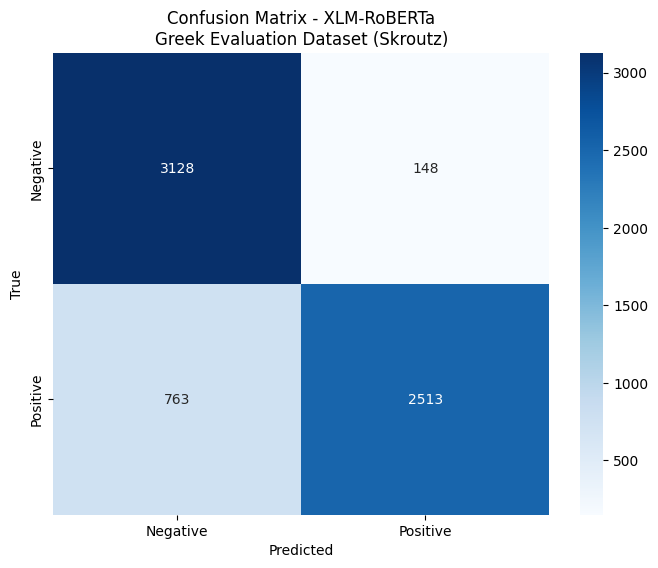

In [ ]:
output = trainer.predict(tokenized_greek_skroutz)
y_preds = np.argmax(output.predictions, axis=-1)
y_true = output.label_ids

cm = confusion_matrix(y_true, y_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Greek Evaluation Dataset (Skroutz)')
plt.show()

## mDeBERTa v3

In [ ]:
!pip install sentencepiece

In [ ]:
model_name = "microsoft/mdeberta-v3-base"
tokenized_youtube_dataset_split= create_tokenized_dataset(model_name, dataset_youtube_split, 128)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/47998 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [ ]:
tokenized_youtube_dataset_split["train"][0].keys()

dict_keys(['labels', 'input_ids', 'attention_mask'])

In [ ]:
model_mdeberta_v3 = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define the Evaluation Metrics

In [ ]:
def compute_metrics(eval_pred):

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="macro")
    precision = precision_score(labels, predictions, average="macro")
    recall = recall_score(labels, predictions, average="macro")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

### Define Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_mdeberta_v3",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-6,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,
    remove_unused_columns=False
)

### Train the Model

In [ ]:
print(f"Train dataset size: {len(tokenized_youtube_dataset_split['train'])}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Expected steps per epoch: {len(tokenized_youtube_dataset_split['train']) / training_args.per_device_train_batch_size}")

Train dataset size: 47998
Batch size: 16
Expected steps per epoch: 2999.875


In [ ]:
trainer = Trainer(
    model=model_mdeberta_v3,
    args=training_args,
    train_dataset=tokenized_youtube_dataset_split["train"],
    eval_dataset=tokenized_youtube_dataset_split["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.355200,0.342558,0.860000,0.859977,0.860514,0.860140
2,0.322800,0.328380,0.868000,0.867844,0.870418,0.868298
3,0.316100,0.327400,0.870583,0.870544,0.871398,0.870758


TrainOutput(global_step=9000, training_loss=0.36318622165256076, metrics={'train_runtime': 2486.4532, 'train_samples_per_second': 57.911, 'train_steps_per_second': 3.62, 'total_flos': 9471773188611072.0, 'train_loss': 0.36318622165256076, 'epoch': 3.0})

The mdeberta_v3 model has:

*   Accuracy= 0.870583
*   Precision= 0.871398
*   Recall= 0.870758
*   f1= 0.870544

### Model Evaluation on the Skroutz dataset

In [ ]:
skroutz_dataset = Dataset.from_pandas(df_skroutz)

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_greek_fn(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_greek_skroutz = skroutz_dataset.map(tokenize_greek_fn, batched=True)

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/6552 [00:00<?, ? examples/s]

In [ ]:
print("--- Final Evaluation on the Greek Skroutz Dataset ---")
greek_results_from_mdeberta_v3 = trainer.evaluate(tokenized_greek_skroutz)

print(f"Accuracy at greek skroutz data: {greek_results_from_mdeberta_v3['eval_accuracy']:.4f}")
print(f"F1-Score at greek skroutz data: {greek_results_from_mdeberta_v3['eval_f1']:.4f}")
print(f"Precision at greek skroutz data: {greek_results_from_mdeberta_v3['eval_precision']:.4f}")
print(f"Recall at greek skroutz data: {greek_results_from_mdeberta_v3['eval_recall']:.4f}")

--- Final Evaluation on the Greek Skroutz Dataset ---


Accuracy at greek skroutz data: 0.8781
F1-Score at greek skroutz data: 0.8774
Precision at greek skroutz data: 0.8860
Recall at greek skroutz data: 0.8781


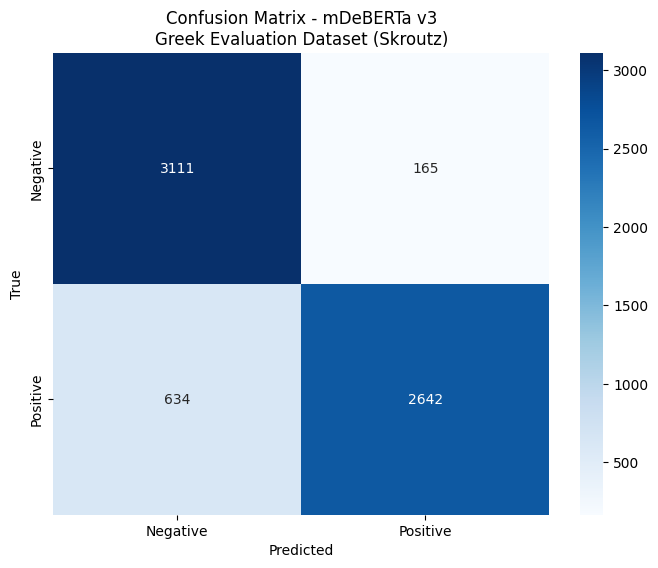

In [ ]:
output = trainer.predict(tokenized_greek_skroutz)
y_preds = np.argmax(output.predictions, axis=-1)
y_true = output.label_ids

cm = confusion_matrix(y_true, y_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - mDeBERTa v3\nGreek Evaluation Dataset (Skroutz)')
plt.show()

## RemBERT

In [ ]:
model_name = "google/rembert"
tokenized_youtube_dataset_split= create_tokenized_dataset(model_name, dataset_youtube_split, 128)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

sentencepiece.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Map:   0%|          | 0/47998 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [ ]:
tokenized_youtube_dataset_split["train"][0].keys()

dict_keys(['labels', 'input_ids', 'attention_mask'])

In [ ]:
model_rembert = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.30G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.30G [00:00<?, ?B/s]

Some weights of RemBertForSequenceClassification were not initialized from the model checkpoint at google/rembert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define the Evaluation Metrics

In [ ]:
def compute_metrics(eval_pred):

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="macro")
    precision = precision_score(labels, predictions, average="macro")
    recall = recall_score(labels, predictions, average="macro")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

### Define Training Arguments

In [ ]:
training_args= TrainingArguments(
    output_dir="./results_rembert",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,
    remove_unused_columns=False
)

### Train the Model

In [ ]:
print(f"Train dataset size: {len(tokenized_youtube_dataset_split['train'])}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Expected steps per epoch: {len(tokenized_youtube_dataset_split['train']) / training_args.per_device_train_batch_size}")

Train dataset size: 47998
Batch size: 4
Expected steps per epoch: 11999.5


In [ ]:
trainer= Trainer(
    model=model_rembert,
    args=training_args,
    train_dataset=tokenized_youtube_dataset_split["train"],
    eval_dataset=tokenized_youtube_dataset_split["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.289400,0.302036,0.882333,0.881852,0.889935,0.882849
2,0.190300,0.373867,0.894500,0.894451,0.895687,0.894706
3,0.089000,0.509703,0.893167,0.893167,0.893209,0.893212


TrainOutput(global_step=9000, training_loss=0.20955470191107856, metrics={'train_runtime': 8765.9779, 'train_samples_per_second': 16.426, 'train_steps_per_second': 1.027, 'total_flos': 5.658915054962995e+16, 'train_loss': 0.20955470191107856, 'epoch': 3.0})

The RemBERT model has:

*   Accuracy= 0.893167
*   Precision= 0.893209
*   Recall= 0.893212
*   f1= 0.893167

### Model Evaluation on the Skroutz dataset

In [ ]:
skroutz_dataset = Dataset.from_pandas(df_skroutz)

# model_name = "google/rembert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_greek_fn(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_greek_skroutz = skroutz_dataset.map(tokenize_greek_fn, batched=True)

Map:   0%|          | 0/6552 [00:00<?, ? examples/s]

In [ ]:
print("--- Final Evaluation on the Greek Skroutz Dataset ---")
greek_results_from_rembert = trainer.evaluate(tokenized_greek_skroutz)

print(f"Accuracy at greek skroutz data: {greek_results_from_rembert['eval_accuracy']:.4f}")
print(f"F1-Score at greek skroutz data: {greek_results_from_rembert['eval_f1']:.4f}")
print(f"Precision at greek skroutz data: {greek_results_from_rembert['eval_precision']:.4f}")
print(f"Recall at greek skroutz data: {greek_results_from_rembert['eval_recall']:.4f}")

--- Final Evaluation on the Greek Skroutz Dataset ---


Accuracy at greek skroutz data: 0.9051
F1-Score at greek skroutz data: 0.9046
Precision at greek skroutz data: 0.9127
Recall at greek skroutz data: 0.9051


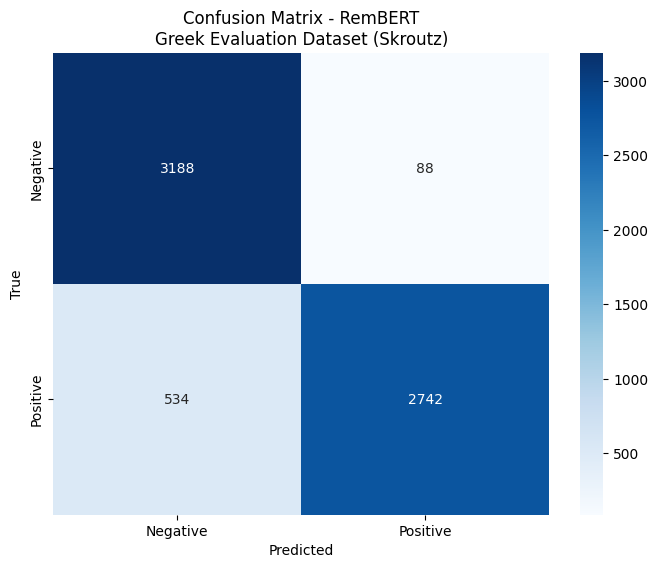

In [ ]:
output = trainer.predict(tokenized_greek_skroutz)
y_preds = np.argmax(output.predictions, axis=-1)
y_true = output.label_ids

cm = confusion_matrix(y_true, y_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Greek Evaluation Dataset (Skroutz)')
plt.show()

#Monolingual Models

Because the monolingual models can not handle the above datasets, we will use a translated version of them.<br>
All the rows translated to english

## Translate datasets

In [ ]:
!pip install deep_translator
from deep_translator import GoogleTranslator
import pandas as pd
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
translator = GoogleTranslator(source='auto', target='en')

def translate_text(text):
    try:
        return translator.translate(text)
    except Exception as e:
        return text

### Translate skroutz dataset (greek comments) into english

In [ ]:
df_skroutz['text_en'] = df_skroutz['text'].progress_apply(translate_text)

In [ ]:
df_skroutz.to_csv('skroutz_dataset_translated.csv', index=False, encoding='utf-8-sig')

### Translate youtube dataset to english

The lang column is used to detect the language of each text, and translation is performed only when it differs from English.

In [ ]:
train_df= pd.read_csv('train_dataset.csv')
test_df= pd.read_csv('test_dataset.csv')

In [ ]:
train_df['text_en'] = train_df['text']

mask = train_df['lang'] != 'en'

for i in train_df[mask].index:
    try:
        train_df.at[i, 'text_en'] = translate_text(train_df.at[i, 'text'])
    except Exception as e:
        print(f"Translation failed for row {i}: {e}")

In [ ]:
test_df['text_en'] = test_df['text']

mask = test_df['lang'] != 'en'

for i in test_df[mask].index:
    try:
        test_df.at[i, 'text_en'] = translate_text(test_df.at[i, 'text'])
    except Exception as e:
        print(f"Translation failed for row {i}: {e}")

In [ ]:
train_df.to_csv('train_df_with_translation.csv', index=False, encoding='utf-8-sig')
test_df.to_csv('test_df_with_translation.csv', index=False, encoding='utf-8-sig')

## Datasets

### Translated Youtube Dataset

In [ ]:
train_df= pd.read_csv("train_df_with_translation.csv")
test_df= pd.read_csv("test_df_with_translation.csv")

In [ ]:
train_df.columns

Index(['text', 'labels', 'lang', 'text_en'], dtype='object')

#### Keeping only the columns text_en and labels

In [ ]:
train_df= train_df[['text_en', 'labels']]
test_df= test_df[['text_en', 'labels']]

#### Rename the column text_en to text

In [ ]:
train_df['text']= train_df['text_en']
train_df= train_df[['text', 'labels']]

test_df['text']= test_df['text_en']
test_df= test_df[['text', 'labels']]

### Translated Skroutz Dataset

In [ ]:
translated_skroutz_df= pd.read_csv("skroutz_dataset_translated.csv")

In [ ]:
translated_skroutz_df.columns

Index(['text', 'labels', 'text_en'], dtype='object')

#### Keeping only the columns text_en and labels

In [ ]:
translated_skroutz_df= translated_skroutz_df[['text_en', 'labels']]

#### Rename the column text_en to text

In [ ]:
translated_skroutz_df['text']= translated_skroutz_df['text_en']
translated_skroutz_df= translated_skroutz_df[['text', 'labels']]

## BERT-base-uncased

In [ ]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

dataset_youtube_split = DatasetDict({
    'train': train_ds,
    'test': test_ds
})

In [ ]:
model_name = "bert-base-uncased"
tokenized_youtube_dataset_split= create_tokenized_dataset(model_name, dataset_youtube_split, 128)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
tokenized_youtube_dataset_split["train"][0].keys()

dict_keys(['labels', 'input_ids', 'attention_mask'])

In [ ]:
model_bert = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define the Evaluation Metrics

In [ ]:
def compute_metrics(eval_pred):

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="macro")
    precision = precision_score(labels, predictions, average="macro")
    recall = recall_score(labels, predictions, average="macro")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

### Define Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_bert",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-6,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,
    remove_unused_columns=False
)

### Train The Model

In [ ]:
print(f"Train dataset size: {len(tokenized_youtube_dataset_split['train'])}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Expected steps per epoch: {len(tokenized_youtube_dataset_split['train']) / training_args.per_device_train_batch_size}")

Train dataset size: 40000
Batch size: 16
Expected steps per epoch: 2500.0


In [ ]:
trainer = Trainer(
    model= model_bert,
    args= training_args,
    train_dataset= tokenized_youtube_dataset_split["train"],
    eval_dataset= tokenized_youtube_dataset_split["test"],
    compute_metrics= compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.380500,0.374127,0.839400,0.838954,0.841937,0.838930
2,0.345000,0.367460,0.847400,0.847221,0.848244,0.847129
3,0.328300,0.364090,0.849900,0.849628,0.851434,0.849540


TrainOutput(global_step=7500, training_loss=0.3683877909342448, metrics={'train_runtime': 1064.566, 'train_samples_per_second': 112.722, 'train_steps_per_second': 7.045, 'total_flos': 7893331660800000.0, 'train_loss': 0.3683877909342448, 'epoch': 3.0})

The BERT-base-uncased model has:

*   Accuracy= 0.849900
*   Precision= 0.851434
*   Recall= 0.849540
*   f1= 0.849628

### Model Evaluation on the Skroutz dataset

In [ ]:
skroutz_dataset = Dataset.from_pandas(translated_skroutz_df)

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_greek_fn(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_greek_skroutz = skroutz_dataset.map(tokenize_greek_fn, batched=True)

Map:   0%|          | 0/6552 [00:00<?, ? examples/s]

In [ ]:
print("--- Final Evaluation on the Greek Skroutz Dataset ---")
greek_results_from_bert = trainer.evaluate(tokenized_greek_skroutz)

print(f"Accuracy at greek skroutz data: {greek_results_from_bert['eval_accuracy']:.4f}")
print(f"F1-Score at greek skroutz data: {greek_results_from_bert['eval_f1']:.4f}")
print(f"Precision at greek skroutz data: {greek_results_from_bert['eval_precision']:.4f}")
print(f"Recall at greek skroutz data: {greek_results_from_bert['eval_recall']:.4f}")

--- Final Evaluation on the Greek Skroutz Dataset ---


Accuracy at greek skroutz data: 0.8594
F1-Score at greek skroutz data: 0.8583
Precision at greek skroutz data: 0.8708
Recall at greek skroutz data: 0.8594


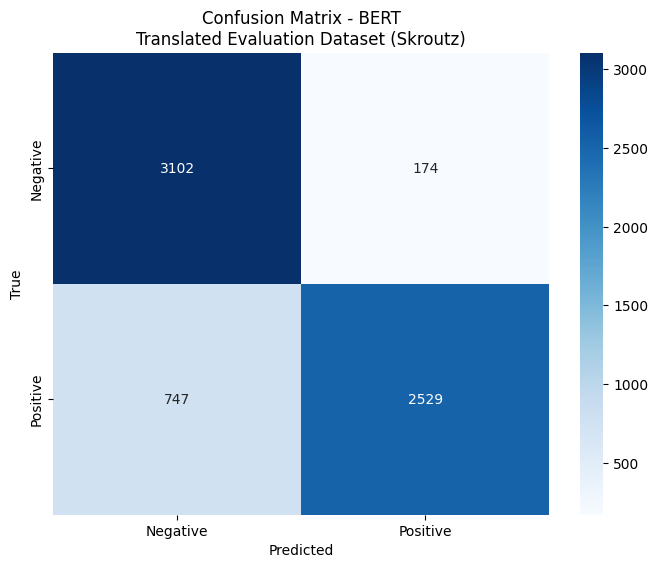

In [ ]:
output = trainer.predict(tokenized_greek_skroutz)
y_preds = np.argmax(output.predictions, axis=-1)
y_true = output.label_ids

cm = confusion_matrix(y_true, y_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - BERT\nTranslated Evaluation Dataset (Skroutz)')
plt.show()

## Preprocessing

Cleans the input text for traditional ML models (RF, SVM, XGBoost)<br>
1. Converts text to lowercase
2. Removes URLs and user mentions (@username).
3. Removes punctuation and special characters.
4. Remove English stop-words and single-letter noise

In [ ]:
train_df['text_en']= train_df['text']
test_df['text_en']= test_df['text']

In [ ]:
import re
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_comments(text):
    text = str(text).lower()

    text = re.sub(r'http\S+|www\S+|@\w+', '', text)

    text = text.translate(str.maketrans('', '', string.punctuation))

    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 1]

    return " ".join(words)

train_df['text_en'] = train_df['text_en'].apply(preprocess_comments)
test_df['text_en'] = test_df['text_en'].apply(preprocess_comments)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Vectorization

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')

x_train_tfidf = vectorizer.fit_transform(train_df['text_en'])
y_train = train_df['labels']

x_test_tfidf = vectorizer.transform(test_df['text_en'])
y_test = test_df['labels']

In [ ]:
translated_skroutz_df['text']= translated_skroutz_df['text'].apply(preprocess_comments)

## Random Forest

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Train Model

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(x_train_tfidf, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

### Metric Scores

In [ ]:
y_pred= rf_model.predict(x_test_tfidf)
print("For Random Forest:")
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Precision Score: ", precision_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))
print("F1-Score: ", f1_score(y_test, y_pred))

For Random Forest:
Accuracy Score:  0.7494
Precision Score:  0.7443910256410257
Recall Score:  0.751314193287505
F1-Score:  0.747836586838398


### Model Evaluation on the Skroutz dataset

In [ ]:
x_skroutz_tfidf = vectorizer.transform(translated_skroutz_df['text'])
y_skroutz = translated_skroutz_df['labels']

y_skroutz_pred = rf_model.predict(x_skroutz_tfidf)

print("--- Final Evaluation on the Greek Skroutz Dataset ---")

print("Accuracy Score: ", accuracy_score(y_skroutz, y_skroutz_pred))
print("Precision Score: ", precision_score(y_skroutz, y_skroutz_pred))
print("Recall Score: ", recall_score(y_skroutz, y_skroutz_pred))
print("F1-Score: ", f1_score(y_skroutz, y_skroutz_pred))

--- Final Evaluation on the Greek Skroutz Dataset ---
Accuracy Score:  0.7286324786324786
Precision Score:  0.8775201612903226
Recall Score:  0.5314407814407814
F1-Score:  0.661977186311787


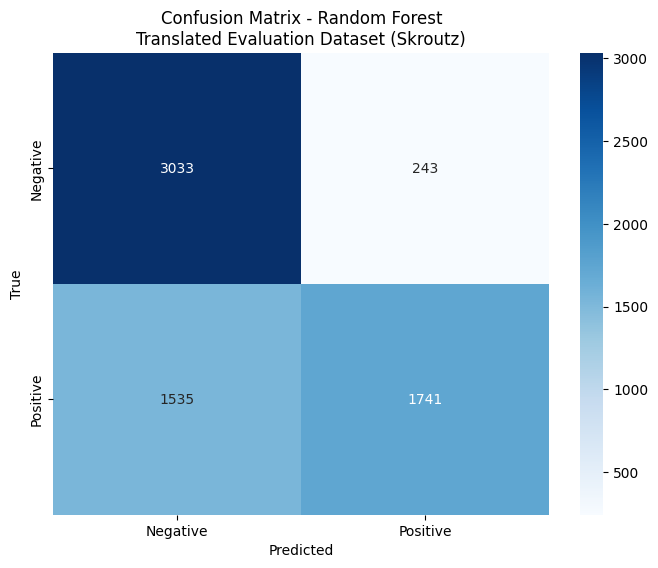

In [ ]:
cm = confusion_matrix(y_skroutz, y_skroutz_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix - Random Forest\nTranslated Evaluation Dataset (Skroutz)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Feature Importance

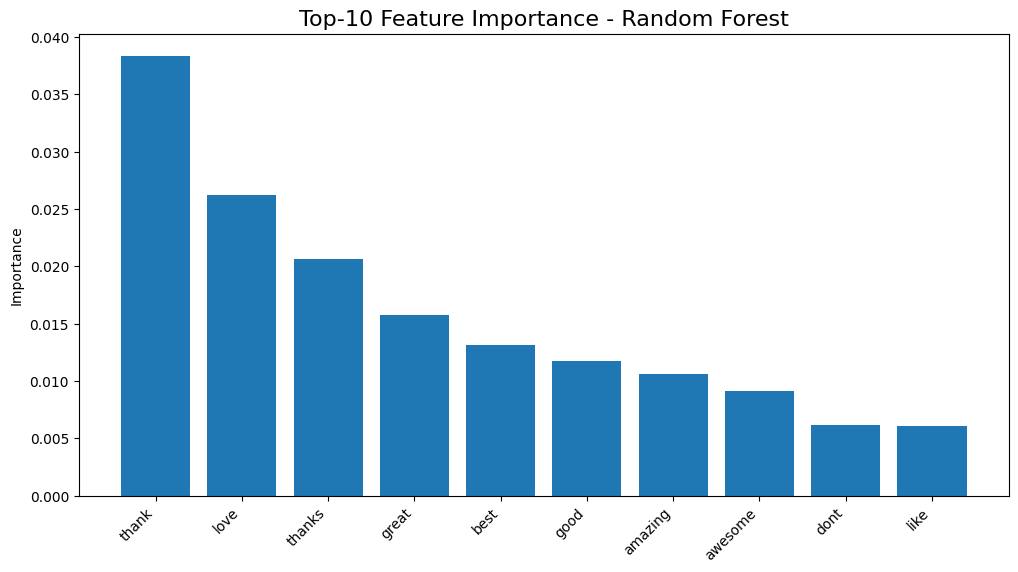

In [ ]:
feature_importances = rf_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)
fi_df = fi_df.head(10)

plt.figure(figsize=(12,6))
plt.bar(fi_df['Feature'], fi_df['Importance'])
plt.xticks(rotation=45, ha="right")
plt.ylabel('Importance')
plt.title('Top-10 Feature Importance - Random Forest', fontsize=16)
plt.show()


## SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

### Train Model

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(LinearSVC(max_iter=10000, random_state=42), param_grid, refit=True, verbose=2, cv=3)
grid.fit(x_train_tfidf, y_train)

print(f"Best Parameters: {grid.best_params_}")
svm_model = grid.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ..............C=0.01, class_weight=None, loss=hinge; total time=   0.4s
[CV] END ..............C=0.01, class_weight=None, loss=hinge; total time=   0.3s
[CV] END ..............C=0.01, class_weight=None, loss=hinge; total time=   0.2s
[CV] END ......C=0.01, class_weight=None, loss=squared_hinge; total time=   0.3s
[CV] END ......C=0.01, class_weight=None, loss=squared_hinge; total time=   0.3s
[CV] END ......C=0.01, class_weight=None, loss=squared_hinge; total time=   0.1s
[CV] END ..........C=0.01, class_weight=balanced, loss=hinge; total time=   0.2s
[CV] END ..........C=0.01, class_weight=balanced, loss=hinge; total time=   0.1s
[CV] END ..........C=0.01, class_weight=balanced, loss=hinge; total time=   0.1s
[CV] END ..C=0.01, class_weight=balanced, loss=squared_hinge; total time=   0.1s
[CV] END ..C=0.01, class_weight=balanced, loss=squared_hinge; total time=   0.1s
[CV] END ..C=0.01, class_weight=balanced, loss=s

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................C=10, class_weight=None, loss=hinge; total time=   7.5s


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................C=10, class_weight=None, loss=hinge; total time=   3.3s


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................C=10, class_weight=None, loss=hinge; total time=   3.6s
[CV] END ........C=10, class_weight=None, loss=squared_hinge; total time=   0.5s
[CV] END ........C=10, class_weight=None, loss=squared_hinge; total time=   0.4s
[CV] END ........C=10, class_weight=None, loss=squared_hinge; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............C=10, class_weight=balanced, loss=hinge; total time=   6.0s


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............C=10, class_weight=balanced, loss=hinge; total time=   3.4s


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............C=10, class_weight=balanced, loss=hinge; total time=   3.2s
[CV] END ....C=10, class_weight=balanced, loss=squared_hinge; total time=   0.2s
[CV] END ....C=10, class_weight=balanced, loss=squared_hinge; total time=   0.3s
[CV] END ....C=10, class_weight=balanced, loss=squared_hinge; total time=   0.3s
Best Parameters: {'C': 0.1, 'class_weight': None, 'loss': 'squared_hinge'}


### Metric Scores

In [ ]:
y_pred= svm_model.predict(x_test_tfidf)
print("For SVM Model:")
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Precision Score: ", precision_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))
print("F1-Score: ", f1_score(y_test, y_pred))

For SVM Model:
Accuracy Score:  0.7669
Precision Score:  0.8049918357825986
Recall Score:  0.6977355438738374
F1-Score:  0.7475360121304018


### Model Evaluation on the Skroutz dataset

In [ ]:
x_skroutz_tfidf = vectorizer.transform(translated_skroutz_df['text'])
y_skroutz = translated_skroutz_df['labels']

y_skroutz_pred = svm_model.predict(x_skroutz_tfidf)

print("--- Final Evaluation on the Greek Skroutz Dataset ---")

print("Accuracy Score: ", accuracy_score(y_skroutz, y_skroutz_pred))
print("Precision Score: ", precision_score(y_skroutz, y_skroutz_pred))
print("Recall Score: ", recall_score(y_skroutz, y_skroutz_pred))
print("F1-Score: ", f1_score(y_skroutz, y_skroutz_pred))

--- Final Evaluation on the Greek Skroutz Dataset ---
Accuracy Score:  0.6767399267399268
Precision Score:  0.9263622974963182
Recall Score:  0.38400488400488403
F1-Score:  0.5429434613724644


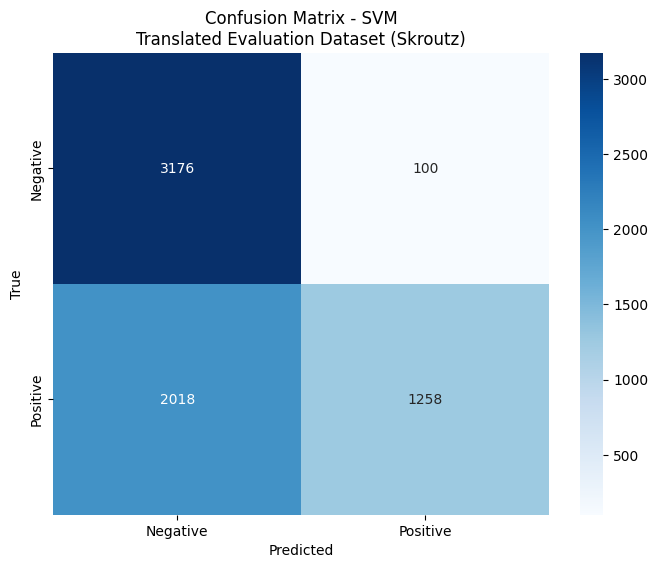

In [ ]:
cm = confusion_matrix(y_skroutz, y_skroutz_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix - SVM\nTranslated Evaluation Dataset (Skroutz)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Importance

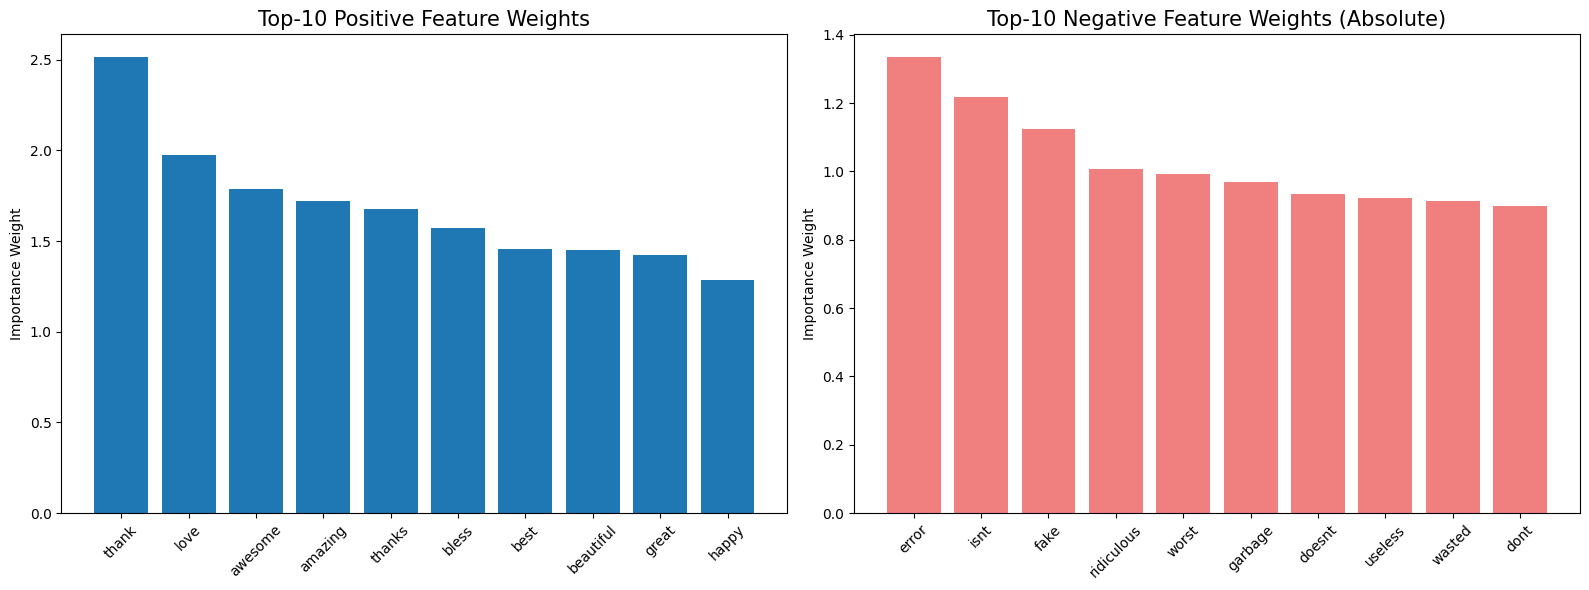

In [ ]:
feature_importances = svm_model.coef_[0]
feature_names = vectorizer.get_feature_names_out()
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

pos_df = fi_df.sort_values(by='Importance', ascending=False).head(10)

neg_df = fi_df.sort_values(by='Importance', ascending=True).head(10)
neg_df['Importance'] = neg_df['Importance'].abs()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(pos_df['Feature'], pos_df['Importance'])
ax1.set_title('Top-10 Positive Feature Weights', fontsize=15)
ax1.set_ylabel('Importance Weight')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(neg_df['Feature'], neg_df['Importance'], color='lightcoral')
ax2.set_title('Top-10 Negative Feature Weights (Absolute)', fontsize=15)
ax2.set_ylabel('Importance Weight')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## XGBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

### Train Model

In [ ]:
xgb_model= XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

random_search = RandomizedSearchCV(
    estimator= xgb_model,
    param_distributions= param_distributions,
    cv= 3,
    scoring= 'f1',
    n_jobs= -1,
    verbose= 2
)

random_search.fit(x_train_tfidf, y_train)

print(f"Best Score: {random_search.best_score_}")
print(f"Best Params: {random_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:32:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Score: 0.7373006698181698
Best Params: {'colsample_bytree': np.float64(0.646569764866542), 'learning_rate': np.float64(0.13323482025066175), 'max_depth': 8, 'n_estimators': 871, 'subsample': np.float64(0.9301126046388973)}


### Metric Scores

In [ ]:
xgb_model = random_search.best_estimator_

y_pred= xgb_model.predict(x_test_tfidf)
print("For SVM Model:")
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Precision Score: ", precision_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))
print("F1-Score: ", f1_score(y_test, y_pred))

For SVM Model:
Accuracy Score:  0.7558
Precision Score:  0.7978116079923881
Recall Score:  0.6781237363526081
F1-Score:  0.7331147540983607


### Model Evaluation on the Skroutz dataset

In [ ]:
x_skroutz_tfidf = vectorizer.transform(translated_skroutz_df['text'])
y_skroutz = translated_skroutz_df['labels']

y_skroutz_pred = xgb_model.predict(x_skroutz_tfidf)

print("--- Final Evaluation on the Greek Skroutz Dataset ---")

print("Accuracy Score: ", accuracy_score(y_skroutz, y_skroutz_pred))
print("Precision Score: ", precision_score(y_skroutz, y_skroutz_pred))
print("Recall Score: ", recall_score(y_skroutz, y_skroutz_pred))
print("F1-Score: ", f1_score(y_skroutz, y_skroutz_pred))

--- Final Evaluation on the Greek Skroutz Dataset ---
Accuracy Score:  0.6775030525030525
Precision Score:  0.8332378223495702
Recall Score:  0.4438339438339438
F1-Score:  0.5791674965146385


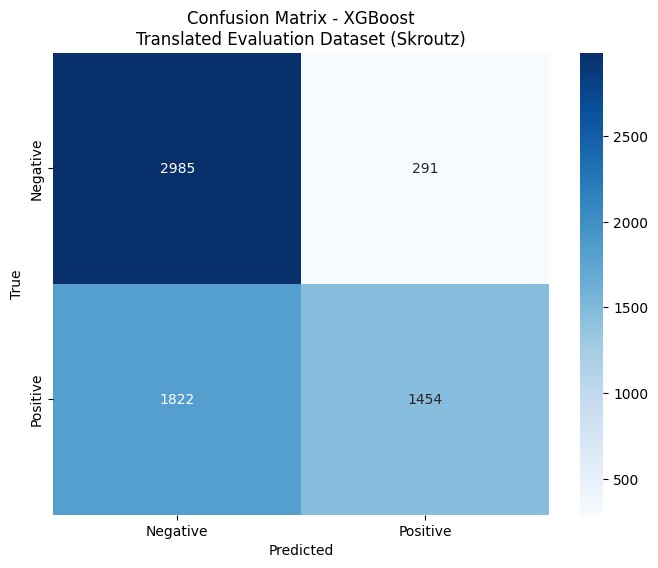

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_skroutz, y_skroutz_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix - XGBoost\nTranslated Evaluation Dataset (Skroutz)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Feature Importance

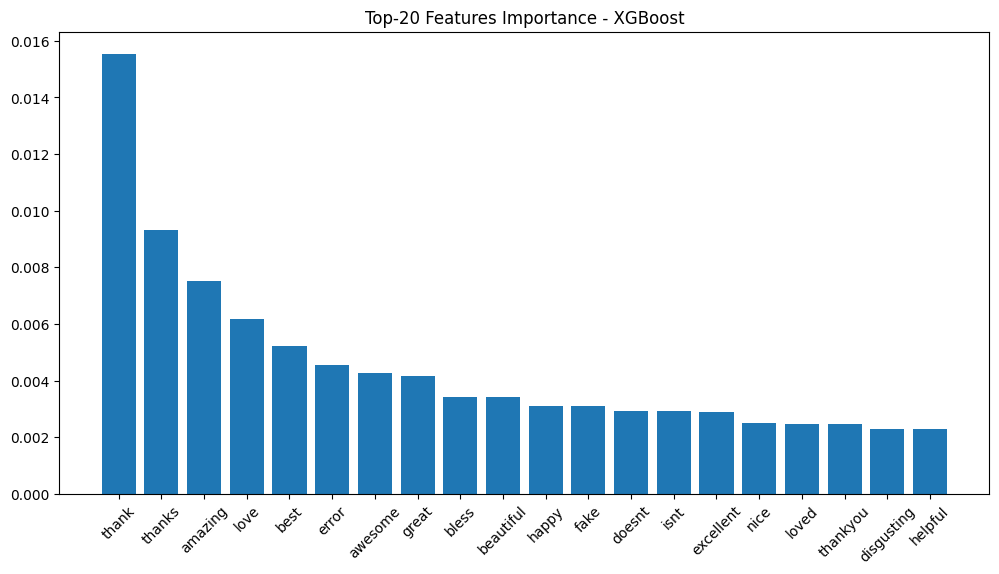

In [ ]:
importances = xgb_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df['Feature'].head(20), feature_importance_df['Importance'].head(20))
plt.tick_params(axis='x', rotation=45)

plt.title("Top-20 Features Importance - XGBoost")
plt.show()